# Credit Card Fraud Detection 

**InternShip Details:**
- **Name:** M HARISH GAUTHAM
- **Project ID:** #CC69844
- **Project Title:** Credit Card Fraud Detection
- **Internship Domain:** Data Science Intern
- **Project Level:** Intermediate Level
- **Assigned By:** CodeClause Internship

This notebook walks through:
- Downloading the dataset from Kaggle
- Loading and splitting the dataset
- Training multiple models with visualizations
- Evaluating performance with imbalance-aware metrics
- Comparing models with visual analysis

In [ ]:
# Install and import dependencies

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, classification_report

# Import from src directory
import sys
sys.path.append('../src')

from data_utils import load_creditcard_data
from models import build_models
from evaluation import evaluate_predictions, print_detailed_report

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [5]:
# Option 1: Use KaggleHub (if working)
try:
    import kagglehub
    print("Attempting to download with kagglehub...")
    # Download the dataset
    path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
    csv_file = os.path.join(path, "creditcard.csv")
    df = pd.read_csv(csv_file)
    print("Dataset loaded successfully from KaggleHub")
except Exception as e:
    print(f"KaggleHub failed: {e}")
    print("Please download creditcard.csv manually from https://www.kaggle.com/mlg-ulb/creditcardfraud")
    print("and place it in the ../data/ directory")
    # For now, let's assume you have the file
    if os.path.exists("../data/creditcard.csv"):
        df = pd.read_csv("../data/creditcard.csv")
        print("Using existing dataset file")
    else:
        raise FileNotFoundError("Please download the dataset first")

# Save to data directory
os.makedirs("../data", exist_ok=True)
df.to_csv("../data/creditcard.csv", index=False)
print(f"Dataset saved to ../data/creditcard.csv")
print(f"Dataset shape: {df.shape}")
print(f"Fraud cases: {df['Class'].sum()}")
print(f"Non-fraud cases: {len(df) - df['Class'].sum()}")
print(f"Fraud percentage: {df['Class'].mean() * 100:.4f}%")

Attempting to download with kagglehub...
KaggleHub failed: module 'kagglehub' has no attribute 'dataset_download'
Please download creditcard.csv manually from https://www.kaggle.com/mlg-ulb/creditcardfraud
and place it in the ../data/ directory
Using existing dataset file
Dataset saved to ../data/creditcard.csv
Dataset shape: (284807, 31)
Fraud cases: 492
Non-fraud cases: 284315
Fraud percentage: 0.1727%


In [6]:
# Load and split the data
(X_train,
 X_val,
 X_test,
 y_train,
 y_val,
 y_test,
 scaler,) = load_creditcard_data("../data/creditcard.csv")

models = build_models()

print("Data loaded successfully!")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Feature count: {X_train.shape[1]}")

# Class distribution
train_fraud_pct = y_train.mean() * 100
val_fraud_pct = y_val.mean() * 100
test_fraud_pct = y_test.mean() * 100

print(f"\nFraud percentages:")
print(f"Training: {train_fraud_pct:.4f}%")
print(f"Validation: {val_fraud_pct:.4f}%")
print(f"Test: {test_fraud_pct:.4f}%")

Data loaded successfully!
Training set: 199364 samples
Validation set: 28481 samples
Test set: 56962 samples
Feature count: 30

Fraud percentages:
Training: 0.1731%
Validation: 0.1720%
Test: 0.1720%


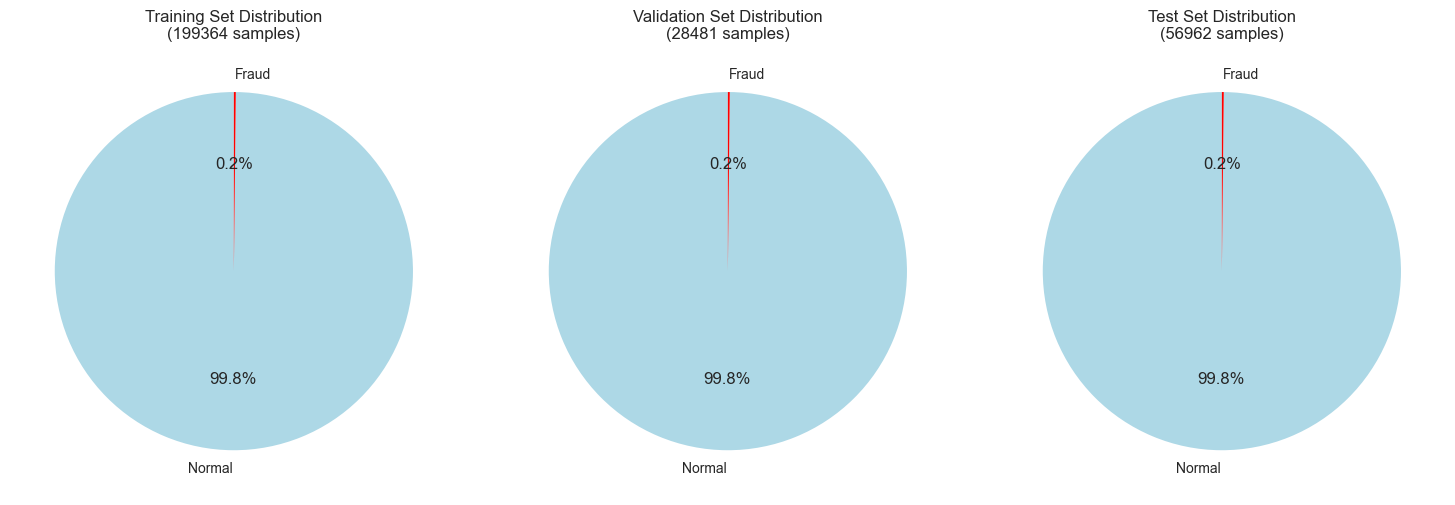

In [7]:
# Visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Training set
train_counts = pd.Series(y_train).value_counts().sort_index()
train_counts.index = ['Normal', 'Fraud']
axes[0].pie(train_counts.values, labels=train_counts.index, autopct='%1.1f%%', 
            colors=['lightblue', 'red'], startangle=90)
axes[0].set_title(f'Training Set Distribution\n({X_train.shape[0]} samples)')

# Validation set
val_counts = pd.Series(y_val).value_counts().sort_index()
val_counts.index = ['Normal', 'Fraud']
axes[1].pie(val_counts.values, labels=val_counts.index, autopct='%1.1f%%', 
            colors=['lightblue', 'red'], startangle=90)
axes[1].set_title(f'Validation Set Distribution\n({X_val.shape[0]} samples)')

# Test set
test_counts = pd.Series(y_test).value_counts().sort_index()
test_counts.index = ['Normal', 'Fraud']
axes[2].pie(test_counts.values, labels=test_counts.index, autopct='%1.1f%%', 
            colors=['lightblue', 'red'], startangle=90)
axes[2].set_title(f'Test Set Distribution\n({X_test.shape[0]} samples)')

plt.tight_layout()
plt.show()

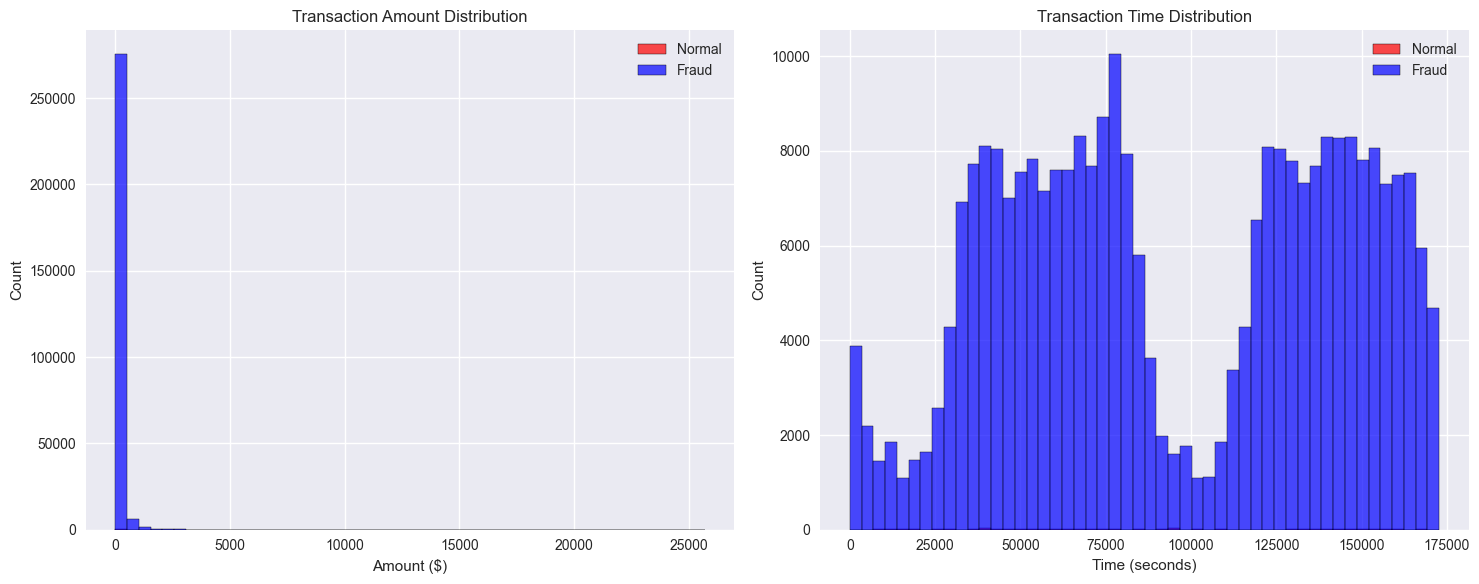

In [8]:
# Visualize feature distributions
# Load original data to show feature distributions
df_orig = pd.read_csv("../data/creditcard.csv")

# Plot Amount and Time distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Amount distribution
sns.histplot(data=df_orig, x='Amount', hue='Class', bins=50, 
             ax=axes[0], palette=['blue', 'red'], alpha=0.7)
axes[0].set_title('Transaction Amount Distribution')
axes[0].set_xlabel('Amount ($)')
axes[0].set_ylabel('Count')
axes[0].legend(['Normal', 'Fraud'])

# Time distribution
sns.histplot(data=df_orig, x='Time', hue='Class', bins=50, 
             ax=axes[1], palette=['blue', 'red'], alpha=0.7)
axes[1].set_title('Transaction Time Distribution')
axes[1].set_xlabel('Time (seconds)')
axes[1].set_ylabel('Count')
axes[1].legend(['Normal', 'Fraud'])

plt.tight_layout()
plt.show()

In [9]:
# Train all models and collect results
results = {}

for name, model in models.items():
    print(f"\n=== Training {name.upper()} ===")
    model.fit(X_train, y_train)
    
    y_val_pred = model.predict(X_val)
    y_val_proba = None
    if hasattr(model, "predict_proba"):
        y_val_proba = model.predict_proba(X_val)[:, 1]
    elif hasattr(model, "decision_function"):
        y_val_proba = model.decision_function(X_val)
    
    metrics = evaluate_predictions(y_val, y_val_pred, y_val_proba)
    results[name] = {
        'model': model,
        'metrics': metrics,
        'predictions': y_val_pred,
        'probabilities': y_val_proba
    }
    
    print(f"F1 Score: {metrics.get('f1', 0):.4f}")
    print(f"ROC-AUC: {metrics.get('roc_auc', 0):.4f}")
    print(f"PR-AUC: {metrics.get('pr_auc', 0):.4f}")

print("\n" + "="*50)
print("MODEL TRAINING COMPLETED")
print("="*50)


=== Training LOG_REG ===


C:\Users\hariv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


F1 Score: 0.1124
ROC-AUC: 0.9614
PR-AUC: -0.6692

=== Training DECISION_TREE ===
F1 Score: 0.6882
ROC-AUC: 0.8263
PR-AUC: -0.6905

=== Training RANDOM_FOREST ===
F1 Score: 0.8095
ROC-AUC: 0.9257
PR-AUC: -0.7980

=== Training GRAD_BOOST ===
F1 Score: 0.6420
ROC-AUC: 0.8161
PR-AUC: -0.6648

MODEL TRAINING COMPLETED


In [10]:
# Compare model performance
model_names = list(results.keys())
f1_scores = [results[name]['metrics'].get('f1', 0) for name in model_names]
roc_aucs = [results[name]['metrics'].get('roc_auc', 0) for name in model_names]
pr_aucs = [results[name]['metrics'].get('pr_auc', 0) for name in model_names]

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': model_names,
    'F1 Score': f1_scores,
    'ROC-AUC': roc_aucs,
    'PR-AUC': pr_aucs
})

print("Model Performance Comparison:")
print(comparison_df.to_string(index=False))

Model Performance Comparison:
        Model  F1 Score  ROC-AUC    PR-AUC
      log_reg  0.112450 0.961434 -0.669218
decision_tree  0.688172 0.826320 -0.690465
random_forest  0.809524 0.925707 -0.797988
   grad_boost  0.641975 0.816075 -0.664793


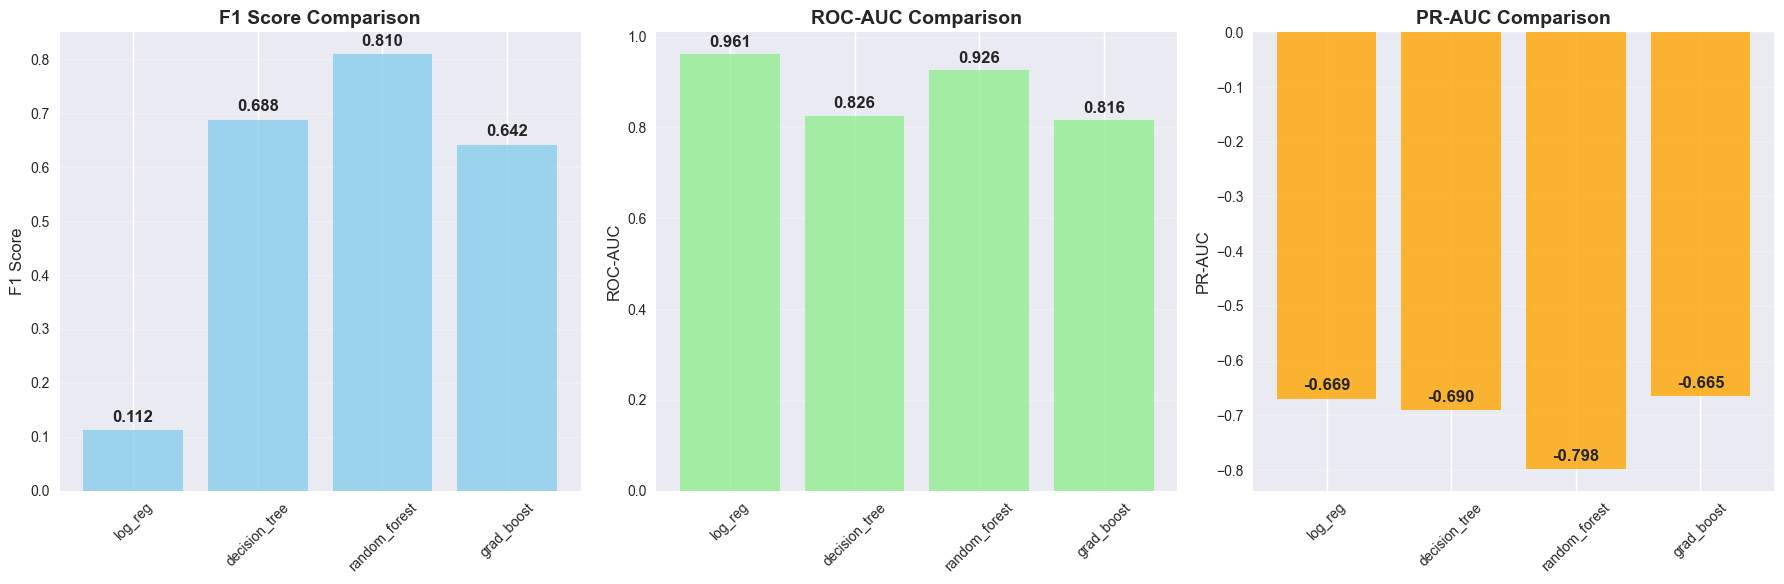

In [11]:
# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# F1 Score comparison
bars1 = axes[0].bar(model_names, f1_scores, color='skyblue', alpha=0.8)
axes[0].set_title('F1 Score Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('F1 Score', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, score in zip(bars1, f1_scores):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

# ROC-AUC comparison
bars2 = axes[1].bar(model_names, roc_aucs, color='lightgreen', alpha=0.8)
axes[1].set_title('ROC-AUC Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('ROC-AUC', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, score in zip(bars2, roc_aucs):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

# PR-AUC comparison
bars3 = axes[2].bar(model_names, pr_aucs, color='orange', alpha=0.8)
axes[2].set_title('PR-AUC Comparison', fontsize=14, fontweight='bold')
axes[2].set_ylabel('PR-AUC', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, score in zip(bars3, pr_aucs):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [12]:
# Select best model by F1 score
best_name = max(results, key=lambda k: results[k]['metrics'].get("f1", 0.0))
best_model = results[best_name]['model']
best_metrics = results[best_name]['metrics']

print(f"Best Model: {best_name.upper()}")
print(f"F1 Score: {best_metrics.get('f1', 0):.4f}")
print(f"ROC-AUC: {best_metrics.get('roc_auc', 0):.4f}")
print(f"PR-AUC: {best_metrics.get('pr_auc', 0):.4f}")

# Retrain best model on train+val
import numpy as np

X_train_val = np.vstack([X_train, X_val])
y_train_val = np.concatenate([y_train, y_val])

print(f"\nRetraining {best_name.upper()} on combined train+val set ({X_train_val.shape[0]} samples)...")
best_model.fit(X_train_val, y_train_val)

# Final evaluation on test set
y_test_pred = best_model.predict(X_test)
y_test_proba = None
if hasattr(best_model, "predict_proba"):
    y_test_proba = best_model.predict_proba(X_test)[:, 1]
elif hasattr(best_model, "decision_function"):
    y_test_proba = best_model.decision_function(X_test)

test_metrics = evaluate_predictions(y_test, y_test_pred, y_test_proba)
print("\n" + "="*50)
print("FINAL TEST RESULTS")
print("="*50)
print(f"F1 Score: {test_metrics.get('f1', 0):.4f}")
print(f"ROC-AUC: {test_metrics.get('roc_auc', 0):.4f}")
print(f"PR-AUC: {test_metrics.get('pr_auc', 0):.4f}")

Best Model: RANDOM_FOREST
F1 Score: 0.8095
ROC-AUC: 0.9257
PR-AUC: -0.7980

Retraining RANDOM_FOREST on combined train+val set (227845 samples)...

FINAL TEST RESULTS
F1 Score: 0.8523
ROC-AUC: 0.9573
PR-AUC: -0.8684


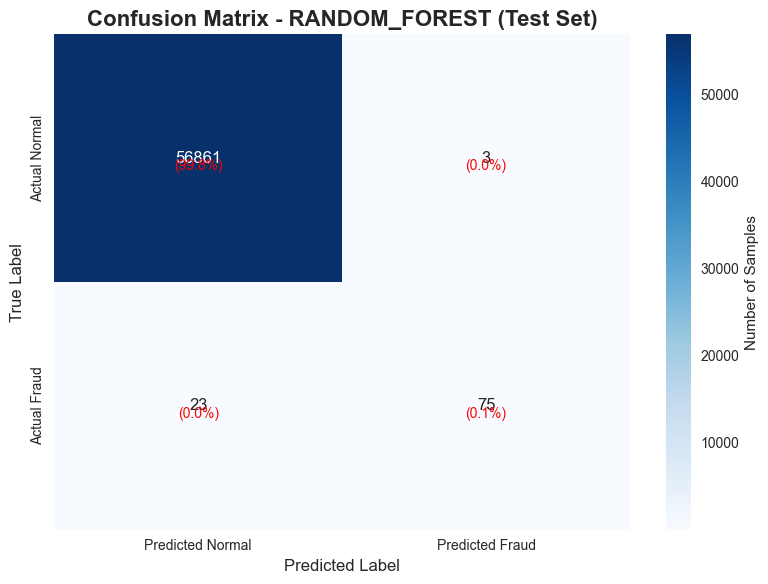


Detailed Classification Report:
----------------------------------------
Confusion matrix:
[[56861     3]
 [   23    75]]

Classification report:
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56864
           1     0.9615    0.7653    0.8523        98

    accuracy                         0.9995     56962
   macro avg     0.9806    0.8826    0.9260     56962
weighted avg     0.9995    0.9995    0.9995     56962



In [13]:
# Confusion Matrix for Best Model
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Normal', 'Predicted Fraud'],
            yticklabels=['Actual Normal', 'Actual Fraud'],
            cbar_kws={'label': 'Number of Samples'})

plt.title(f'Confusion Matrix - {best_name.upper()} (Test Set)', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

# Add percentage annotations
total = cm.sum()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        percentage = cm[i, j] / total * 100
        plt.text(j + 0.5, i + 0.5, f'\n({percentage:.1f}%)', 
                ha='center', va='center', fontsize=10, color='red')

plt.tight_layout()
plt.show()

# Print detailed classification report
print("\nDetailed Classification Report:")
print("-"*40)
print_detailed_report(y_test, y_test_pred)

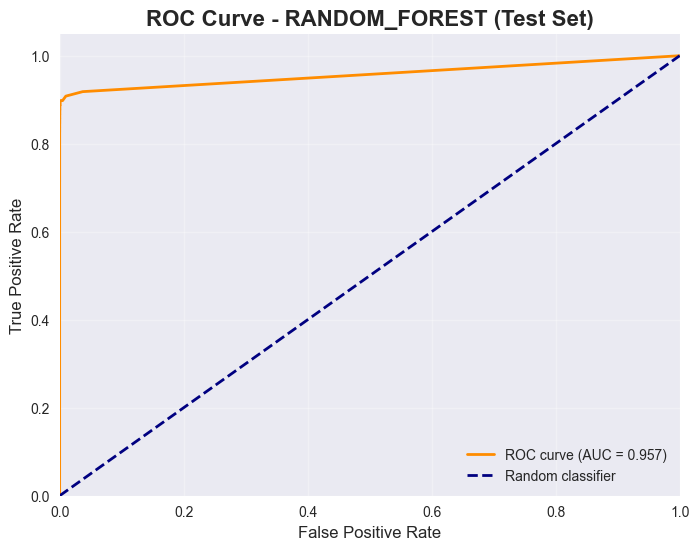

In [14]:
# ROC Curve for Best Model
if y_test_proba is not None:
    fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
    roc_auc = test_metrics.get('roc_auc', 0)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curve - {best_name.upper()} (Test Set)', fontsize=16, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()
else:
    print("ROC curve not available for this model type")

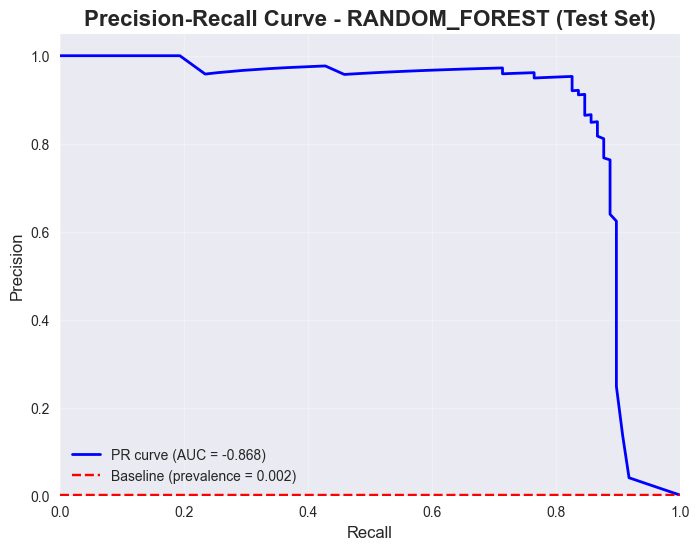

In [15]:
# Precision-Recall Curve for Best Model
if y_test_proba is not None:
    precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)
    pr_auc = test_metrics.get('pr_auc', 0)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, 
             label=f'PR curve (AUC = {pr_auc:.3f})')
    
    # Add baseline (fraction of positive samples)
    baseline = y_test.mean()
    plt.axhline(y=baseline, color='red', linestyle='--', 
                label=f'Baseline (prevalence = {baseline:.3f})')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(f'Precision-Recall Curve - {best_name.upper()} (Test Set)', fontsize=16, fontweight='bold')
    plt.legend(loc="lower left")
    plt.grid(alpha=0.3)
    plt.show()
else:
    print("Precision-Recall curve not available for this model type")

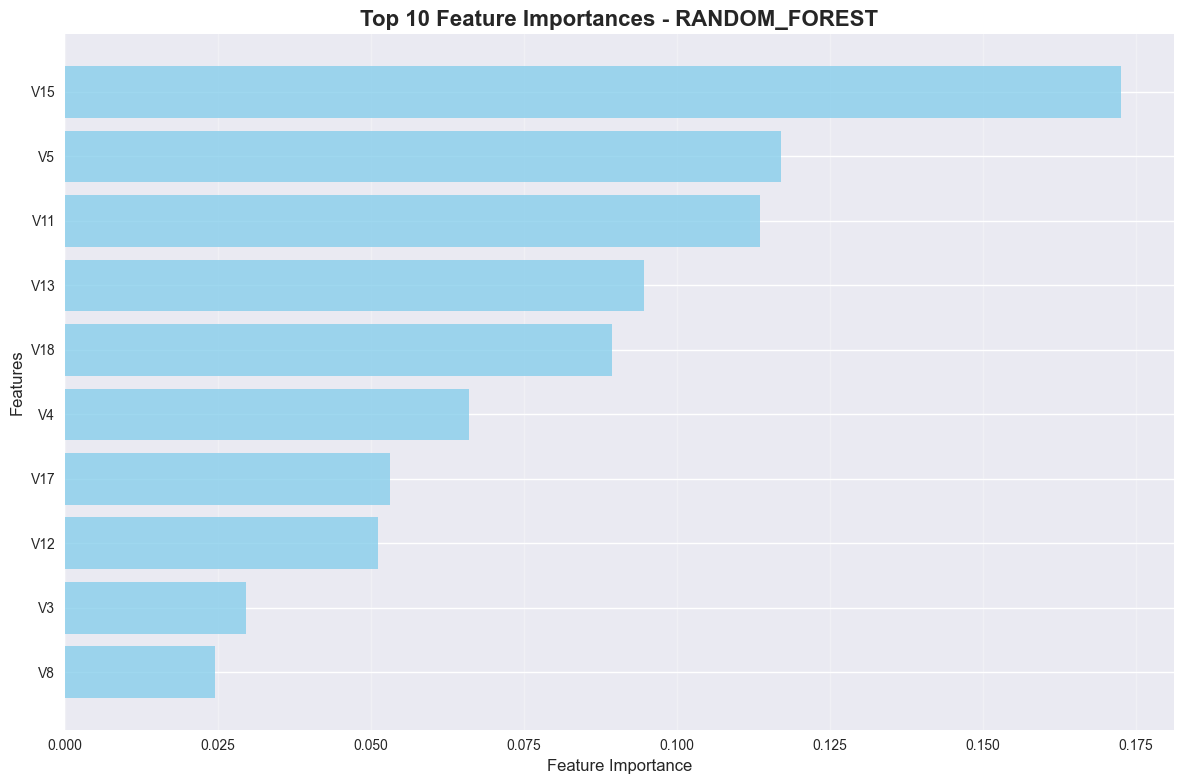


Top 10 Most Important Features:
-----------------------------------
 1.      V15: 0.1726
 2.       V5: 0.1169
 3.      V11: 0.1136
 4.      V13: 0.0945
 5.      V18: 0.0893
 6.       V4: 0.0661
 7.      V17: 0.0531
 8.      V12: 0.0512
 9.       V3: 0.0296
10.       V8: 0.0245


In [16]:
# Feature Importance (if available)
if hasattr(best_model, 'feature_importances_'):
    # Get feature names (V1-V28, Amount, Time)
    feature_names = [f'V{i}' for i in range(1, 29)] + ['Amount', 'Time']
    
    # Get feature importances
    importances = best_model.feature_importances_
    
    # Sort by importance
    indices = np.argsort(importances)[::-1]
    
    # Plot top 10 features
    plt.figure(figsize=(12, 8))
    top_n = min(10, len(feature_names))
    plt.barh(range(top_n), importances[indices][:top_n][::-1], 
             color='skyblue', alpha=0.8)
    plt.yticks(range(top_n), [feature_names[i] for i in indices][:top_n][::-1])
    plt.xlabel('Feature Importance', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.title(f'Top {top_n} Feature Importances - {best_name.upper()}', fontsize=16, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print feature importance ranking
    print("\nTop 10 Most Important Features:")
    print("-"*35)
    for i in range(min(10, len(indices))):
        idx = indices[i]
        print(f"{i+1:2d}. {feature_names[idx]:>8s}: {importances[idx]:.4f}")
        
elif hasattr(best_model, 'coef_'):
    # For linear models, show coefficient magnitudes
    feature_names = [f'V{i}' for i in range(1, 29)] + ['Amount', 'Time']
    coefs = np.abs(best_model.coef_[0])
    
    # Sort by coefficient magnitude
    indices = np.argsort(coefs)[::-1]
    
    # Plot top 10 features
    plt.figure(figsize=(12, 8))
    top_n = min(10, len(feature_names))
    plt.barh(range(top_n), coefs[indices][:top_n][::-1], 
             color='lightcoral', alpha=0.8)
    plt.yticks(range(top_n), [feature_names[i] for i in indices][:top_n][::-1])
    plt.xlabel('Coefficient Magnitude', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.title(f'Top {top_n} Feature Coefficients - {best_name.upper()}', fontsize=16, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print coefficient ranking
    print("\nTop 10 Features by Coefficient Magnitude:")
    print("-"*42)
    for i in range(min(10, len(indices))):
        idx = indices[i]
        print(f"{i+1:2d}. {feature_names[idx]:>8s}: {coefs[idx]:.4f}")
else:
    print(f"\nFeature importance not available for {best_name.upper()} model type")

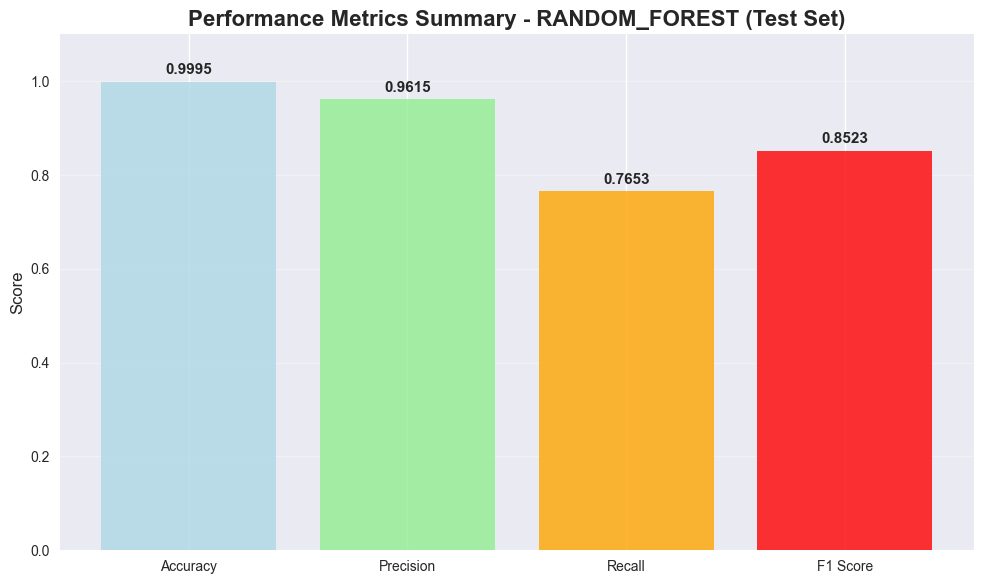


FINAL SUMMARY
Best Model: RANDOM_FOREST
Test F1 Score: 0.8523
Test ROC-AUC: 0.9573
Test PR-AUC: -0.8684

Dataset: 284807 transactions
Fraud rate: 0.17%

Pipeline completed successfully! 🎉


In [17]:
# Summary visualization - All metrics for best model
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
metrics_values = [
    test_metrics.get('accuracy', 0),
    test_metrics.get('precision', 0),
    test_metrics.get('recall', 0),
    test_metrics.get('f1', 0)
]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics_names, metrics_values, color=['lightblue', 'lightgreen', 'orange', 'red'], alpha=0.8)
plt.title(f'Performance Metrics Summary - {best_name.upper()} (Test Set)', fontsize=16, fontweight='bold')
plt.ylabel('Score', fontsize=12)
plt.ylim(0, 1.1)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, metrics_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

# Final summary
print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)
print(f"Best Model: {best_name.upper()}")
print(f"Test F1 Score: {test_metrics.get('f1', 0):.4f}")
print(f"Test ROC-AUC: {test_metrics.get('roc_auc', 0):.4f}")
print(f"Test PR-AUC: {test_metrics.get('pr_auc', 0):.4f}")
print(f"\nDataset: {len(df)} transactions")
print(f"Fraud rate: {df['Class'].mean() * 100:.2f}%")
print("\nPipeline completed successfully! 🎉")